In [1]:
import cobrame
import cobra
import pickle
import math
import json
from glob import glob
from tqdm import tqdm
from os.path import exists
import seaborn as sns
from matplotlib import pyplot as plt
import palettable
import numpy as np
from collections import OrderedDict
from scipy.stats import ttest_ind, ks_2samp
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

from me_biomass.general_info import met_to_name, aas_to_name
from me_biomass.me_solve_functions import solve_me_model
from me_biomass.load_model import load_me_model
from me_biomass.characterize_solution import *
from me_biomass.load_model import currency_met_to_synthesis_rxn
from me_biomass.update_mpl_rcparams import update_rcparams

from cobrame.util.dogma import amino_acids

%matplotlib inline

/home/sbrg-cjlloyd/cobrapy/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


# Part 1
Run the following to reproduce figures in
- Section 1: Benchmarking ME-model predictions of biomass composition
- Section 2: Growth condition-dependent biomass composition

In [2]:
source_to_name = {'C': 'Carbon', 'P': 'Phosphorus', 'S': 'Sulfur', 'N': 'Nitrogen'}
# filter metal ions and metabolites whose primary role is not as a prosthetic group
prosthetic_group_mets_to_filter = [
    'lys__L_c','nad_c', 'nadp_c', 'ca2_c', 'cl_c', 'cobalt2_c', 'cu2_c', 'fe2_c',
    'fe3_c', 'k_c', 'mg2_c', 'nadh_c', 'nadph_c', 'ni2_c', 'zn2_c', 'mn2_c', 'fad_c', 'nh4_c']
aas = [i[:-2] for i in amino_acids.values()]

In [3]:
me = load_me_model(json=False)

12.0 protein_b3946 --> EG11905-MONOMER
10000.0
coa_p not in model
10000.0
thf_p not in model
10000.0
nadp_p not in model
10000.0
nad_p not in model
10000.0
ribflv_p not in model
10000.0
10000.0
q8_p not in model
10000.0
2dmmq8_p not in model
10000.0
mqn8_p not in model
10000.0
fmn_p not in model
10000.0
fad_p not in model


# (1) Benchmarking ME-model predictions of biomass composition

In [4]:
# run aerobic and anaerobic ME-model simulations
if not exists('./simulations/aerobic.json'):
    me.reactions.EX_o2_e.lower_bound = -1000
    solve_me_model(me, 2.5, using_soplex=False)
    sol1 = me.solution
    me.reactions.EX_o2_e.lower_bound = 0
    solve_me_model(me, 2.5, using_soplex=False)
    sol2 = me.solution
    with open('./simulations/aerobic.json', 'w') as f:
        json.dump(sol1.x_dict, f)
    with open('./simulations/anaerobic.json', 'w') as f:
        json.dump(sol2.x_dict, f)
else:
    with open('./simulations/aerobic.json', 'r') as f:
        x_dict = json.load(f)
    sol1 = cobra.core.Solution(1, x_dict=x_dict, status='optimal')
    with open('./simulations/anaerobic.json', 'r') as f:
        x_dict = json.load(f)
    sol2 = cobra.core.Solution(1, x_dict=x_dict, status='optimal')

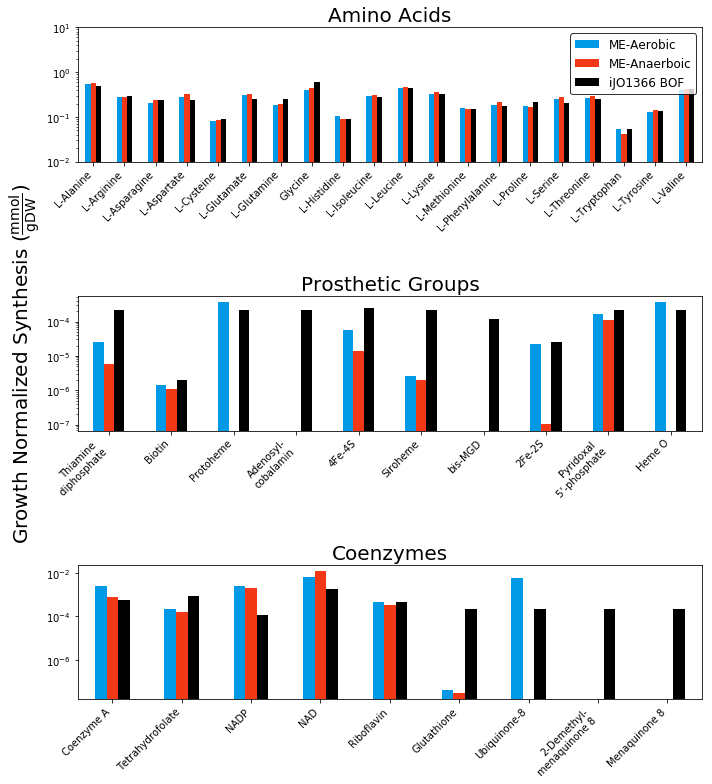

In [5]:
# plot comparision of ME-model simulations to iJO1366 biomass function
fig, axes = plt.subplots(3, 1, figsize=(10, 11))
update_rcparams()
met_list = []
for i, kind in enumerate(['amino_acid', 'cofactors', 'coenzymes']):
    if kind in ['amino_acid', 'cofactors']:
        comp1 = compare_to_ijo_biomass(me, solution=sol1, kind=kind)
        comp2 = compare_to_ijo_biomass(me, solution=sol2, kind=kind)
        if kind == 'cofactors':
            for met in prosthetic_group_mets_to_filter: 
                comp1.drop([met], inplace=True, errors='ignore')
                comp2.drop([met], inplace=True, errors='ignore')
    else:
        comp1 = compare_cofactor_to_ijo_biomass(me, currency_met_to_synthesis_rxn=currency_met_to_synthesis_rxn,
                                                solution=sol1)
        comp2 = compare_cofactor_to_ijo_biomass(me, currency_met_to_synthesis_rxn=currency_met_to_synthesis_rxn, 
                                                solution=sol2)
        
    logy = True
    joined = comp1.join(comp2, rsuffix='_ana')
    

    joined.rename(lambda x: x.replace("_c", ''), inplace=True)
    joined.drop('Measured_ana', axis=1, inplace=True)

    joined.columns = ['ME-Aerobic', 'iJO1366 BOF', 'ME-Anaerboic']
    
    ax = axes[i]
    
    legend=False
    if kind == 'amino_acid':
        title = 'Amino Acids'
        legend = True
    elif kind == 'cofactors':
        title = 'Prosthetic Groups'
    elif kind == 'coenzymes':
        title = 'Coenzymes'
    joined.rename(met_to_name, inplace=True)
    plt.rcParams['legend.facecolor'] = 'w'
    joined[['ME-Aerobic', 'ME-Anaerboic', 'iJO1366 BOF']].plot(kind='bar', logy=logy, ax=ax,
                                                               color=['#0099E6', '#F23814', '#000000'],
                                                               legend=legend)
    
    ax.set_xticklabels(joined.index, fontdict={'horizontalalignment': 'right', 'rotation':45})
    ax.set_title(title)
    ax.set_facecolor('w')
    met_list.extend([i for i in joined.index])
axes[0].set_ylim([.01, 10])
axes[1].set_ylabel(r'Growth Normalized Synthesis ($\mathrm{\frac{mmol}{gDW}}$)', size=20)
ax.figure.tight_layout()
ax.figure.subplots_adjust(hspace=1)
ax.figure.savefig('./output/figure_2.png')

# (2) Growth condition-dependent biomass composition

In [6]:
def rename_columns(df):
    full = False
    col_names = []
    for i in df.columns:
        if 'iron' in i:
            col_names.append('iron')
            continue
        try:
            met = me.metabolites.get_by_id(i + '_c')
        except:
            met = me.metabolites.get_by_id(i)
        if not met.name:
            met.name = met.id.replace("_c", '')
        elif met.id == 'nadp_c':
            met.name = 'nadp'
        elif met.id == 'nad_c':
            met.name = 'nad'
        elif met.id == 'fad_c':
            met.name = 'fad'
        if not full:
            met.name = met.id.replace("_c", "")
        col_names.append(met.name)

    df.columns = col_names
    return df


def get_cofactor_demand(df, growth_norm):
    
    out_dict = {}
    for c in tqdm(df.columns):
        x_dict = df[c].to_dict()
        sol = cobra.core.Solution(1, x_dict=x_dict, status='optimal')
        out_dict[c] = {}
        
        # get coenzyme, prosthetic group, and amino acid demands
        cofactors = compare_to_ijo_biomass(me, solution=sol, kind='cofactors', 
                                           growth_norm=growth_norm)
        prosthetic = compare_cofactor_to_ijo_biomass(
            me, currency_met_to_synthesis_rxn=currency_met_to_synthesis_rxn, 
            solution=sol, growth_norm=growth_norm)
        aas = compare_to_ijo_biomass(me, solution=sol, kind='amino_acid', growth_norm=growth_norm)
        
        # update output with biomass component demands
        out_dict[c].update(aas.drop('Measured', axis=1).to_dict().popitem()[1])
        out_dict[c].update(cofactors.drop('Measured', axis=1).drop(
            prosthetic_group_mets_to_filter, errors='ignore').to_dict().popitem()[1])
        out_dict[c].update(prosthetic.drop('Measured', axis=1).drop(
            prosthetic_group_mets_to_filter, errors='ignore').to_dict().popitem()[1])
    return pd.DataFrame(out_dict).T


def get_color_for_conditions(cluster_df):
    color_df = pd.DataFrame()
    color_dict = {'N': 'g', 'C': 'k', 'P':'r', 'S':'y'}
    ana_color_dict = {'N': '#90ee90', 'C': '#D3D3D3', 'P': '#ff6961', 'S': '#ffffe0'}
    for i in cluster_df.index:
        if 'anaerobic' in i:
            color_df.loc[i, 'Nutrient Source'] = ana_color_dict[i.split('_')[0]]
        else:
            color_df.loc[i, 'Nutrient Source'] = color_dict[i.split('_')[0]]
    return color_df


def summarize_conditions(df, normalize_by_element_uptake=True, growth_norm=True, split=False):

    condition_df = get_cofactor_demand(df, growth_norm)
        
    # these do not consider glutathione as a substrate since it is a cofactor
    condition_df.drop(['C_gthrd_e', 'S_gthrd_e', 'N_gthrd_e', 
                     'C_anaerobic_gthrd_e', 'S_anaerobic_gthrd_e', 
                     'N_anaerobic_gthrd_e'], inplace=True, errors='ignore')
    

    condition_df = rename_columns(condition_df)
    return condition_df


In [7]:
full_dict = {}
for fi in glob('./simulations/media_sims/*'):
    with open(fi, 'r') as f:
        x_dict = json.load(f)
    fi = fi.split('/')[-1].replace('_sol.json', '')
    if 'anaerobic' in fi:
        name = fi.replace('anaerobic_', '').replace('_EX_', '_anaerobic_')
    else:
        name = fi.replace('aerobic_', '').replace('_EX_', '_')
    full_dict[name] = x_dict
    
full_df = pd.DataFrame(full_dict)
df = full_df.dropna(axis=1).copy()

In [8]:
full_df = full_df.fillna(0)
reorg_df = pd.DataFrame()
for i in full_df.columns:
    if 'anaerobic' in i:
        met = i.split('aerobic_')[-1][:-2]
        source = source_to_name[i[0]] + ' anaerobic'
    else:
        met = '_'.join(i.split('_')[1:-1])
        source = source_to_name[i[0]] + ' aerobic'
    reorg_df.loc[source, met] = full_df.loc['biomass_dilution', i]
    
reorg_df.T.fillna('').to_excel('./output/S1_data.xlsx')

/home/sbrg-cjlloyd/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:106 UserWarning: Pandas requires version '0.9.8' or newer of 'xlsxwriter' (version '0.9.6' currently installed).


In [9]:
print('total number of conditions', reorg_df.clip(lower=1, upper=1).sum().sum())
print('total number of aerobic conditions', reorg_df.loc[[i for i in reorg_df.index if 'anaerobic' not in i]].clip(lower=1, upper=1).sum().sum())
growth_support_df = reorg_df.copy()
growth_support_df[growth_support_df>0.01] =1
print('total number of growth-supporting aerobic conditions', growth_support_df.loc[[i for i in reorg_df.index if 'anaerobic' not in i]].sum().sum())
print('total number of growth-supporting conditions', growth_support_df.sum().sum())

total number of conditions 1114.0
total number of aerobic conditions 557.0
total number of growth-supporting aerobic conditions 330.0
total number of growth-supporting conditions 592.0


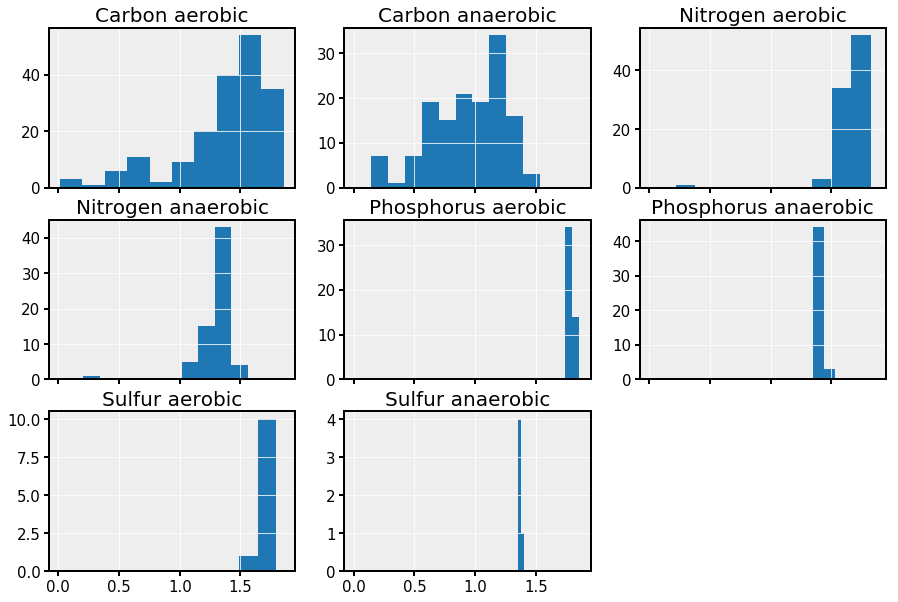

In [10]:
# plot distribution of growth rates by nutrient conditions
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
iter_axes = iter(axes.flatten())
hist_df = reorg_df.copy()
hist_df[hist_df == 0] = np.nan
for index in hist_df.sort_index().index:
    if 'Carbon' not in index and 'Nitrogen' not in index:
        bins = 2
    else:
        bins = 10
    ax = next(iter_axes)
    _ = hist_df.loc[index].hist(ax=ax, bins=bins)
    ax.set_title(index)
axes.flatten()[-1].remove()
fig.savefig('./output/growth_rates.png')

In [13]:
condition_df_file = './output/condition_df.csv'

if not exists(condition_df_file):

    condition_df = summarize_conditions(df, growth_norm=True)
    condition_df.to_csv(condition_df_file)
else:
    condition_df = pd.read_csv(condition_df_file, index_col=0)
color_df = get_color_for_conditions(condition_df)

condition_df = condition_df.dropna(how='all')

### (Figure 4) PCA showing how micronutrient use differentiates conditions

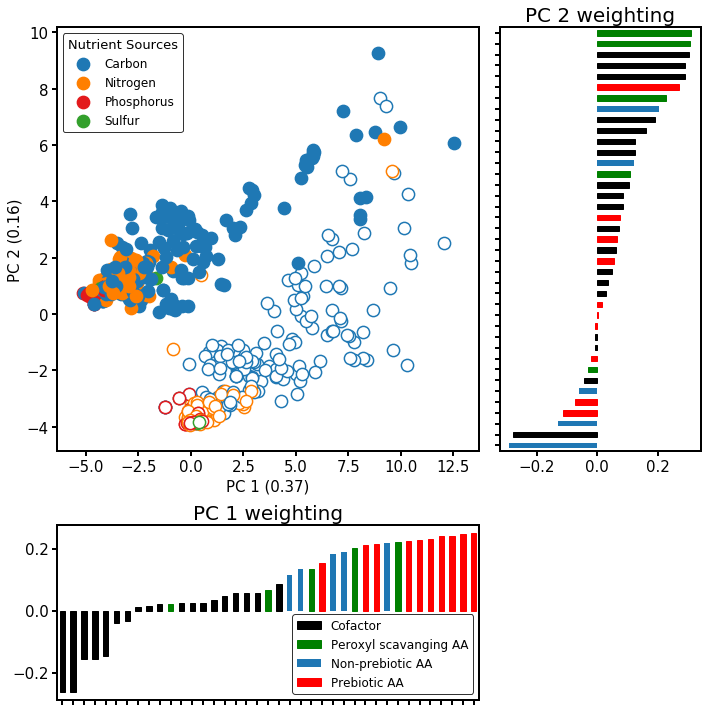

In [14]:

# run PCA
pca_df = condition_df.copy()
expression_values = preprocessing.StandardScaler().fit_transform(pca_df)
pca = PCA(n_components=3)
a = pca.fit(expression_values)
X_r = a.transform(expression_values)


fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(3, 3)
ax = fig.add_subplot(gs[:-1, :-1])

source_to_color = dict(zip(['C_anaerobic', 'C', 'S_anaerobic', 'S', 'P_anaerobic', 'P', 'N_anaerobic', 'N'], 
                          palettable.colorbrewer.qualitative.Paired_8.hex_colors))


# plot and format points on PCA plot
for z in range(len(X_r[:, 0])):
    index = pca_df.index[z]
    source = index.split('_')[0] if 'anaerobic' not in index else '_'.join(index.split('_')[:2]) 
    if 'anaerobic' in source:
        edgecolor = source_to_color[source.split('_')[0]]
        color = 'white'
        label=None
    else:
        edgecolor = None
        label=source_to_name[source]
        color  = source_to_color[source.split('_')[0]]
    ax.scatter(X_r[z, 0], X_r[z, 1], c=color, edgecolors=edgecolor, s=150, label=label, linewidths=1.5)
    
    
ax.set_xlabel('PC 1 (%.2f)' % a.explained_variance_ratio_[0])
ax.set_ylabel('PC 2 (%.2f)' % a.explained_variance_ratio_[1])
ax.set_facecolor('w')
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels[:-1], handles[:-1]))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', facecolor='w', ncol=1, title='Nutrient Sources',
         title_fontsize=13)

# plot PCA weightings
all_weights=pd.DataFrame()
for component in [0, 1]:
    if component == 0:
        ax = fig.add_subplot(gs[-1, :-1])
        bar_kind = 'bar'
    else:
        ax = fig.add_subplot(gs[:-1, -1])
        bar_kind = 'barh'
    ax.set_facecolor('w')
    weight_dfs = pd.DataFrame(a.components_[component], index=pca_df.columns).T
    all_weights = all_weights.join(weight_dfs.T, how='outer', rsuffix='new')
    # from https://www.pnas.org/content/110/6/2135
    # inspired by https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4906156/
    prebiotic_aas = ['ala__L', 'asp__L', 'glu__L', 'gly', 'ile__L', 
                     'leu__L', 'pro__L', 'ser__L', 'thr__L', 'val__L']
    peroyl_scavanging = ['his__L', 'cys__L', 'met__L', 'tyr__L', 'trp__L']
    weight_dfs.sort_values(0, axis=1).loc[0].plot(kind=bar_kind, ax=ax)
    for i, p in enumerate(ax.patches):
        if weight_dfs.sort_values(0, axis=1).columns[i] in prebiotic_aas:
            p.set_color('r')
            p.set_label('Prebiotic AA')
        elif weight_dfs.sort_values(0, axis=1).columns[i] in peroyl_scavanging:
            p.set_color('g')
            p.set_label('Peroxyl scavanging AA')
        elif '__L' not in weight_dfs.sort_values(0, axis=1).columns[i]:
            p.set_color('k')
            p.set_label('Cofactor')
        else:
            p.set_label('Non-prebiotic AA')
    ax.set_title('PC %i weighting' % (component+1))

    if component == 0:
        ax.set_xticklabels(['']* len(weight_dfs.sort_values(0, axis=1).columns))
            # remove duplicate legend entries
        handles, labels = ax.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels[:-1], handles[:-1]))
        ax.legend(by_label.values(), by_label.keys(), ncol=1, facecolor='w')
    else:
        ax.set_yticklabels(['']* len(weight_dfs.sort_values(0, axis=1).columns))


fig.tight_layout()
fig.savefig('./output/figure_4.svg')
all_weights.columns = ['PC 1', 'PC 2']

all_weights.sort_values('PC 1', ascending=False).applymap(lambda x: '%.3f' % x).to_csv(
    './figure_4_pc_weightings.csv')

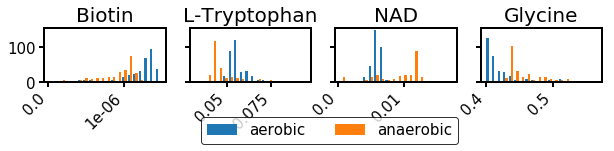

In [16]:
# plot histograms of specificy metabolites
hist_df = condition_df.copy()
to_plot = list(reversed(['gly', 'nad', 'trp__L', 'btn']))
fig, axes = plt.subplots(1, 4, figsize=(10, 1), sharey=True)
for i, col in enumerate(to_plot):
    if col not in to_plot:
        continue
    ax=axes[i]
    ax.set_facecolor('w')
    if col != 'nad':
        ax.set_title(ijo.metabolites.get_by_id(col+'_c').name.replace('amide', 'amide \n'))
    else:
        ax.set_title('NAD')
    ana = [i for i in hist_df.index if 'anaerobic' in i]
    aer = [i for i in hist_df.index if 'anaerobic' not in i]
    ax.hist([hist_df.loc[aer, col], hist_df.loc[ana, col]], bins=20)
    ax.set_xticklabels([round(i, 7) for i in ax.get_xticks()], 
                  fontdict={'horizontalalignment': 'right', 'rotation':45})
ax.legend(['aerobic', 'anaerobic'], bbox_to_anchor=(-1.25, -.5), loc='upper center', fontsize=15, ncol=2,
         facecolor='w')

fig.savefig('./output/hist_for_pca_figure_4.svg')

## (Figure 3) Standard deviation analysis of nutrient sources

/home/sbrg-cjlloyd/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:203 UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'


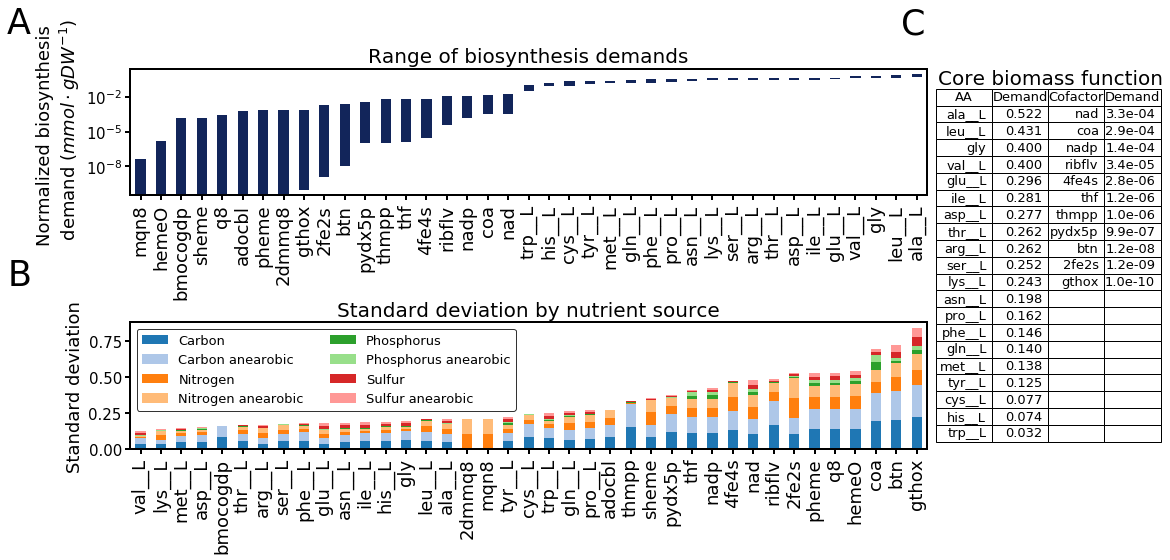

In [20]:
fig  = plt.figure(figsize=(18,7))
gs = fig.add_gridspec(2, 5)
ax = fig.add_subplot(gs[0,:-1])
plot_df = condition_df.copy()
c2, c1 = palettable.wesanderson.Zissou_5.hex_colors[0:2]
ax = plot_df.max().sort_values().plot(kind='bar', logy=True,
                                      label='max-min', ax=ax, color=c1)

ax = plot_df.min().sort_values().plot(kind='bar', logy=True, ax=ax,
                                      color='w')
ax.set_facecolor('w')
ax.set_ylabel('Normalized biosynthesis \n demand' + r' ($mmol \cdot gDW^{-1}$)', fontsize=18)
ax.set_title('Range of biosynthesis demands')
ax.set_xticklabels(ax.get_xticklabels(), 
                  fontdict={'fontsize': 18})

aer = [i for i in condition_df.index if 'anaerob' not in i]
anaer = [i for i in condition_df.index if 'anaerob' in i]
all_values ={}
for kind, lis in zip(['aerobic', 'anaerobic'], [aer, anaer]):
    q = condition_df.loc[aer]/ condition_df.loc[aer].T.max(axis=1)
    sources = set([i.split('_')[0] for i in q.index])
    
    sorted_all = q.T.std(axis=1).sort_values().index

    for s in sources:
        source_rxns = [i for i in q.index if i.startswith(s)]
        key = source_to_name[s] if kind == 'aerobic' else source_to_name[s]+' anearobic'
        all_values[key] =dict(zip(sorted_all, list(q.loc[source_rxns, sorted_all].T.std(axis=1).values)))

ax = fig.add_subplot(gs[1,:-1])
all_val_df = pd.DataFrame(all_values)
all_val_df['sum'] = all_val_df.sum(axis=1)
all_val_df = all_val_df.sort_values('sum')
all_val_df[sorted(all_val_df.columns)].drop(['sum'], axis=1).plot.bar(
    stacked=True, colors=palettable.tableau.Tableau_20.hex_colors, ax=ax)
ax.set_facecolor('w')
ax.legend(facecolor='w', ncol=2, fontsize=13)#, title='Nutrient Sources', title_fontsize=12)
ax.set_ylabel('Standard deviation', fontsize=18)
ax.set_title('Standard deviation by nutrient source')
ax.set_xticklabels(ax.get_xticklabels(), 
                  fontdict={'fontsize': 18})

fig.subplots_adjust(hspace=1)
fig.text(.03, .95, 'A', size=35)
fig.text(.03, .45, 'B', size=35)


for i in plot_df.index:
    plot_df.loc[i, 'aerobicity'] = 'anaerobic' if 'anaerobic' in i else 'aerobic'
plot_df = plot_df.drop('atp', axis=1, errors='ignore')
core_biomass = pd.DataFrame(plot_df.drop('aerobicity', axis=1).min())
core_biomass = core_biomass[core_biomass>0].dropna().sort_values(0, ascending=False)
core_biomass.index.name = 'Metabolite'
core_biomass.columns = ['Demand']
core_biomass = core_biomass.applymap(lambda x: '%.3f' % x if x>1e-3 else '{:.1e}'.format(float(x)))
core_biomass = core_biomass.reset_index()
core_out = pd.DataFrame(index=list(range(20)), columns=list(range(4)))
core_out.iloc[:20, 0] = core_biomass.iloc[:20, 0]
core_out.iloc[:20, 1] = core_biomass.iloc[:20, 1]
core_out.iloc[:11, 2] = core_biomass.iloc[20:, 0].values
core_out.iloc[:11, 3] = core_biomass.iloc[20:, 1].values
core_out.columns = ['AA', 'Demand', 'Cofactor', 'Demand']

ax = fig.add_subplot(gs[:, -1])
ax.axis('off')
ax.axis('tight')
t =ax.table(cellText=core_out.fillna('').values, colLabels=core_out.columns, loc='lower center')
t.auto_set_font_size(False)
t.set_fontsize(13)
t.scale(1.3,1.4)
fig.text(.72, .95, 'C', size=35)
fig.text(.835, .85, 'Core biomass function', size=20, ha='center')

fig.savefig('./output/figure_3.png')

## Cluster aerobic growth conditions (Figure 5)

In [22]:
p_cutoff = 1e-5
small_cluster_cutoff = 3
to_skip = ['bmocogdp', 'adocbl', '2dmmq8', 'mqn8', 'sheme']
filt_df = condition_df.loc[[i for i in condition_df.index if 'anaerobic' not in i]]
filt_df = filt_df[[i for i in filt_df if i != 'atp' and i not in to_skip]]
filt_df = filt_df.astype(float) 

norm_df = filt_df / filt_df.max()
#z_df = pd.DataFrame(z_df, index=filt_df.index, columns=filt_df.columns)
summary=pd.DataFrame()

for n_clus in [6]:
    fit = AgglomerativeClustering(n_clusters=int(n_clus), linkage='ward',
                                  affinity='euclidean').fit(norm_df)

    out_df = pd.DataFrame([norm_df.index, fit.labels_], index=['met', 'cluster']).T

    drop_indexes = []
    p_df = pd.DataFrame()
    new_df = pd.DataFrame()
    sizes = []
    for clust, temp_df in out_df.groupby('cluster'):
        mets = [i for i in temp_df.met]
        
        non_clust_mets = [i for i in out_df.met if i not in mets]

        sizes.append(len(mets))
        new_df.loc[clust, 'mets'] = ', '.join(mets)
        for cofactor in norm_df.columns:

            clust_values = norm_df.loc[mets, cofactor].values
            non_clust_values = norm_df.loc[non_clust_mets, cofactor].values
            p_df.loc[clust, cofactor] = ks_2samp(clust_values, non_clust_values)[1]
            new_df.loc[clust, cofactor] = clust_values.mean() / non_clust_values.mean()
    
    binary_p_df = p_df.copy()
    binary_p_df[binary_p_df > p_cutoff] = 0
    binary_p_df[(binary_p_df <= p_cutoff) & ( binary_p_df >0)] = 1
            
    summary.loc[n_clus, 'num_sig'] = binary_p_df.sum(axis=1).sum()
    summary.loc[n_clus, 'num_clus'] = len(p_df.index)
    summary.loc[n_clus, 'avg_num_sig'] = binary_p_df.sum(axis=1).mean()
    summary.loc[n_clus, 'avg_size'] = np.array(sizes).mean()
    summary.loc[n_clus, 'num_sig_clus'] = (binary_p_df.sum(axis=1) > 0).sum()
    
clus_to_skip = []
for i in new_df.index:
    if len(new_df.loc[i, 'mets'].split(', ')) <= small_cluster_cutoff:
        clus_to_skip.append(i)
        
print(len(new_df.index))
summary
norm_df.to_csv("./output/normalized_condition_df.csv")



6


In [24]:
biomass_compositions = pd.DataFrame()
for cluster_num in new_df.index:
    mets = new_df.loc[cluster_num, 'mets'].split(', ')
    column_name = 'Cluster ' + str(cluster_num + 1)
    biomass_compositions[column_name] = condition_df.drop(to_skip,axis=1).loc[mets].mean()
    biomass_compositions.loc['Conditions in cluster', column_name] =  new_df.loc[cluster_num, 'mets']
    
biomass_compositions.T.to_csv('./output/S2_data.xlsx')

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:56 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sbrg-cjlloyd/.local/lib/python3.6/site-packages/pandas/core/generic.py:5208 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


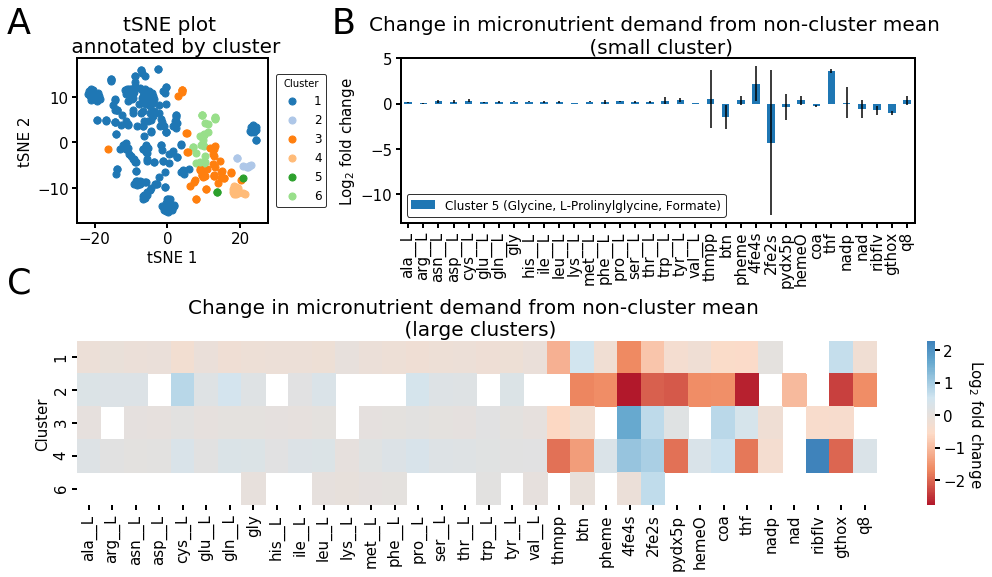

In [28]:
fig  = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(2, 7)

# TSNE
sne_df = norm_df.copy()

ax = fig.add_subplot(gs[0, :2])
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(preprocessing.StandardScaler().fit_transform(sne_df))
#pca = PCA(n_components=2)
#X_embedded = pca.fit_transform(StandardScaler().fit_transform(sne_df))
#print(pca.explained_variance_ratio_)
clus_to_skip_temp = []
small_cluster_cutoff = 0
clust_to_color = dict(zip([i for i in new_df.index if i not in clus_to_skip_temp], 
                          palettable.tableau.Tableau_20.hex_colors))
for i, name in enumerate(filt_df.index):
    for clus in new_df.index:
        clus_mets = new_df.loc[clus, 'mets'].split(', ')
        if name in clus_mets and len(clus_mets)>(small_cluster_cutoff):

            label = 'cluster %i' % clus
            c = clust_to_color[clus]
            ax.scatter(X_embedded[i, 0], X_embedded[i, 1], c=c, label=clus, s=50)
        elif name in clus_mets:
            ax.scatter(X_embedded[i, 0], X_embedded[i, 1], c='k', label=100, s=10)
handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if int(label)+1 not in label_list:
        handle_list.append(handle)
        label_list.append(int(label)+1)

labels = np.array(sorted(zip(label_list, handle_list)))[:, 0]
handles = np.array(sorted(zip(label_list, handle_list)))[:, 1] 
labels = ['small clusters' if str(i) == '101' else i for i in labels ]
ax.legend(handles, labels, ncol=1, bbox_to_anchor=(1.01, .5), loc='center left',
         title='Cluster', facecolor='w')
ax.set_facecolor('w')
ax.set_ylabel('tSNE 2')
ax.set_xlabel('tSNE 1')
ax.set_title('tSNE plot \n annotated by cluster')
#fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/tnse_fig.svg')


# KEEP
for i in new_df.index:
    changes = binary_p_df.loc[i][binary_p_df.loc[i] > 0].index
    add_str = ''
    for change in changes:
        add_str += ', %s (%.2f)' % (change, new_df.loc[i, change])
    new_df.loc[i, 'changes'] = add_str.strip(', ')
save_df = new_df[['mets', 'changes']]
save_df.index.name = 'Cluster'
save_df.index = save_df.index.map(lambda x: x+1)
save_df['n_mets'] = save_df.mets.map(lambda x: len(x.split(', ')))
def convert_for_table(x):
    out = ''
    for i in x.split(', '):
        out += '(%s) %s, ' % (i[0], ijo.metabolites.get_by_id(i[2:]).name)
    return out
save_df.mets = save_df.mets.map(convert_for_table)
save_df.to_csv('/home/sbrg-cjlloyd/Dropbox/cluster_df.csv')


# heatplot
ax = fig.add_subplot(gs[1,:])
mult_df = binary_p_df[binary_p_df > 0]
heat_df = new_df[[i for i in new_df.columns if i not in ['mets', 'changes']]].applymap(np.log2)
g = sns.heatmap((heat_df * mult_df).drop(clus_to_skip).rename(lambda x: x+1),
           cmap=palettable.colorbrewer.diverging.RdBu_6.get_mpl_colormap(), center=0,
           ax=ax)
g.collections[0].colorbar.set_label('Log$_2$ fold change', rotation=270,
                                    labelpad=20)
ax.set_facecolor('w')
ax.set_title('Change in micronutrient demand from non-cluster mean \n (large clusters)')


ax = fig.add_subplot(gs[0,2:-1])
tmp_df = norm_df.copy() 
heat_df = pd.DataFrame()
for i in new_df.index:
    if i not in clus_to_skip:
        continue
    mets_in_clus = new_df.loc[i, 'mets'].split(', ')
    to_append_df = tmp_df.loc[mets_in_clus]
    non_clus_df = tmp_df.loc[[i for i in tmp_df.index if i not in mets_in_clus]]
    to_append_df.index = [i+1] * len(to_append_df.index)
    
    heat_df = heat_df.append(to_append_df / non_clus_df.mean())
bar_df = np.log2(heat_df)
def get_met_name(x):
    return [ijo.metabolites.get_by_id(i[2:]).name for i in x]
bar_df.index = 'Cluster ' + bar_df.index.astype(str) + new_df.loc[bar_df.index-1, 'mets'].map(
    lambda x: ' (%s)' % ', '.join(get_met_name(x.split(', '))))
mean_df = bar_df.reset_index().groupby('index').mean().T
std_df = bar_df.reset_index().groupby('index').std().T
mean_df.plot(kind='bar', yerr=std_df, ax=ax)
#ax.set_yscale('symlog')
ax.set_facecolor('w')
ax.legend(facecolor='w', loc='lower left')

ax.set_title('Change in micronutrient demand from non-cluster mean \n (small cluster)')
ax.set_ylabel(r'Log$_2$ fold change')
fig.tight_layout()
fig.text(0, .95, 'A', size=35)
fig.text(.3, .95, 'B', size=35)
fig.text(0, .5, 'C', size=35)
fig.savefig('./output//figure_5.png')


Text(0.43, -0.05, 'Normalize nutrient demand')

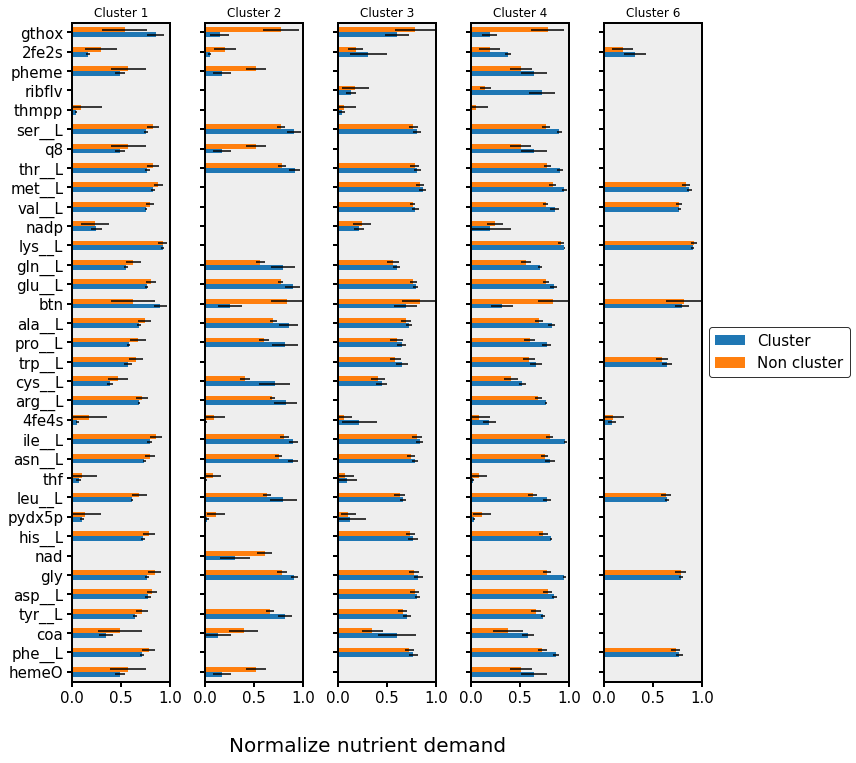

In [29]:

n_big_clus = len(new_df.index) - len(clus_to_skip)
fig, axes = plt.subplots( 1,n_big_clus, figsize=(12, 10), sharey=True, sharex=True)
axes = axes.flatten()
count=0
all_changed = []
for q in new_df.index:
    all_changed.extend([i.split(' (')[0] for i in new_df.loc[q, 'changes'].split(', ')] )
all_changed = [i for i in all_changed if i != '']
plot_df = pd.DataFrame(index=set(all_changed))

for i in new_df.index:
    if i in clus_to_skip:
        continue
        
    cluster = i
    clusts = new_df.loc[cluster, 'mets'].split(', ')
    changed = [i.split(' (')[0] for i in new_df.loc[cluster, 'changes'].split(', ')]
 
    log_df = norm_df.copy()
    plot_df.iloc[:, :] = 0
    if changed ==['']:
        print(clusts)
        count+=1
        continue
    plot_df['mean_clus'] = log_df.loc[clusts, changed].mean()
    plot_df['std_clus'] = log_df.loc[clusts, changed].std()
    plot_df['mean_nonclus'] = log_df.loc[[i for i in log_df.index if i not in clusts], changed].mean()
    plot_df['std_nonclus'] = log_df.loc[[i for i in log_df.index if i not in clusts], changed].std()
    plot_df.plot(kind='barh', y=['mean_clus','mean_nonclus'], 
                 xerr=[plot_df['std_clus'], plot_df['std_nonclus']], ax=axes[count])
    axes[count].legend_ = None
    axes[count].set_title('Cluster %i' % (cluster+1), fontsize=12)
    #axes[count].plot([0,0], [0, 33], 'k--')
    axes[count].set_xlim([0, 1])
    count+=1

axes[count-1].legend(['Cluster', 'Non cluster'], fontsize=15, ncol=1, bbox_to_anchor=(1,.5), loc='center left')
#axes[count-1].s
fig.tight_layout()
fig.text(.43, -.05, 'Normalize nutrient demand', ha='center', fontsize=20)

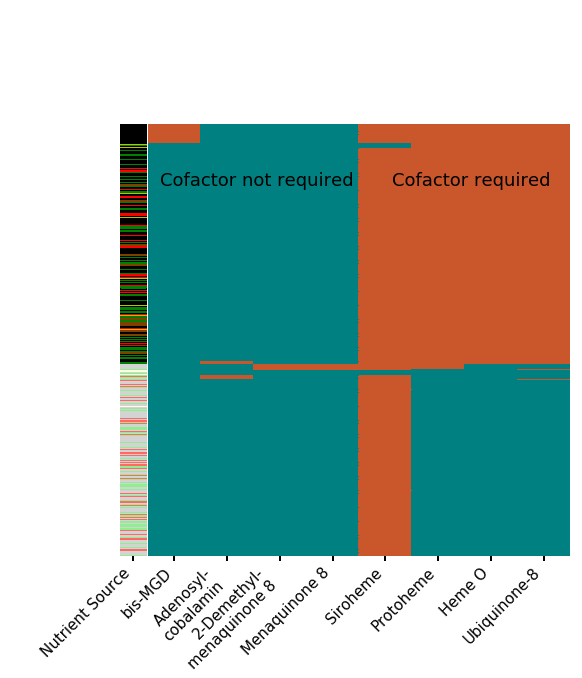

In [31]:
binary_columns = condition_df[condition_df==0].dropna(axis=1, how='all').columns
binary_heat_df = condition_df[binary_columns].copy()
binary_heat_df[binary_heat_df>0] = 1
binary_heat_df.columns = [met_to_name[i.replace('_c', '')]
                          for i in binary_heat_df.columns]
g = sns.clustermap(binary_heat_df, row_colors=color_df, yticklabels=False,
                  cmap=palettable.cartocolors.diverging.Geyser_3.get_mpl_colormap(),
                  method='ward')


g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.cax.clear()
g.cax.axis('off')
g.cax.text(18, -1, 'Cofactor required', fontdict={'fontsize': 18})
g.cax.text(7, -1, 'Cofactor not required', fontdict={'fontsize': 18})
q = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
q = plt.setp(g.ax_row_colors.get_xticklabels(), rotation=45, ha='right')
plt.savefig('./output/conditionally_essential_cofactors.png')

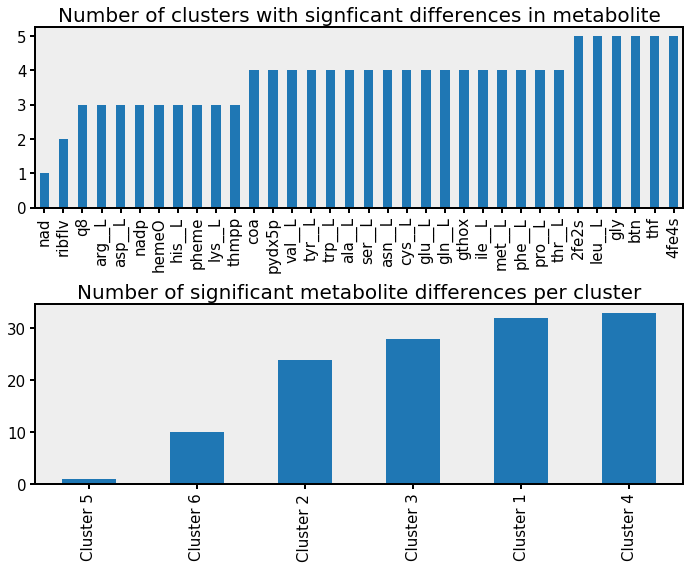

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
binary_p_df.sum().sort_values().plot(kind='bar', ax=axes[0])
axes[0].set_title('Number of clusters with signficant differences in metabolite')


binary_p_df.rename(lambda x: 'Cluster ' + str(x+1)).T.sum().sort_values().plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of significant metabolite differences per cluster')

fig.tight_layout()